In [29]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

import numpy as np


import gml.portfolio.portfolio as portfolio

import os
import sys
sys.path.append(os.path.abspath('../..'))

from laho.tune import Tuner
from multiprocessing import Pool

In [30]:
returns = pd.read_csv("/Users/gmaher/Documents/reports/strat_style_ret/gem3/data/gem3/Y.csv", 
                      index_col=0, parse_dates=True).fillna(0.0)

In [31]:
returns.head()

,EARNYILD,LEVERAGE,DIVYILD,BTOP,SIZE,GROWTH,MOMENTUM,RESVOL
1997-03-04,0.000523,-0.000438,0.000018,-0.000087,-0.000204,0.000199,0.001231,-0.002470
1997-03-05,-0.000784,0.000302,0.000650,-0.000394,-0.000656,-0.000122,0.002068,-0.001420
1997-03-06,-0.000596,0.001010,0.000753,-0.000654,0.000580,-0.000059,-0.000196,0.000819
1997-03-07,0.001013,0.000427,0.000325,-0.000615,0.000509,-0.000468,0.000446,-0.000121
1997-03-10,0.000677,0.000328,0.000005,-0.000167,0.000647,-0.000241,0.000195,0.002724


<Figure size 432x288 with 0 Axes>

/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


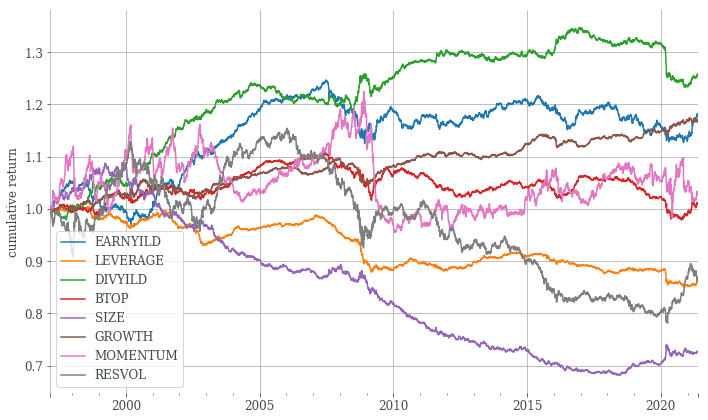

In [32]:
plt.figure()
(1+returns).cumprod().plot(figsize=(10,6))
plt.ylabel("cumulative return")
plt.savefig("../results/factors.png", dpi=300)
plt.show()

In [33]:
returns.std()*np.sqrt(255)

EARNYILD    0.019005
LEVERAGE    0.011134
DIVYILD     0.014597
BTOP        0.014563
SIZE        0.019220
GROWTH      0.011669
MOMENTUM    0.037412
RESVOL      0.034714
dtype: float64

In [34]:
params_config = {
    "alpha_hl":{
        "min":2,
        "max":50,
        "param_type":"int",
        "scale":"log"
    },
    "cov_hl":{
        "min":2,
        "max":50,
        "param_type":"int",
        "scale":"log"
    },
    "vol_target":{
        "min":0.02,
        "max":0.2,
        "scale":"log"
    },
    "tx_cost":{
        "min":0.0,
        "max":10.0/10000
    }
}

objectives_config = {
    "IR":{
        "target":10.0,
        "limit":0.0,
        "priority":1.0
    },
    "max_drawdown":{
        "target":0.0,
        "limit":0.3,
        "priority":1.0
    },
    "mean_return":{
        "target":0.2,
        "limit":0.0,
        "priority":1.0
    }
}

In [35]:
TRAIN_START = "2005-01-01"
TEST_START = "2015-01-01"
TEST_END = "2021-01-01"
TX_REAL = 5.0/10000

ret_train = returns.loc[TRAIN_START:TEST_START]
ret_test = returns.loc[TEST_START:TEST_END]

In [36]:
def run_portfolio(alpha_hl, cov_hl, vol_target, tx_cost, returns):
    alpha = returns.ewm(halflife=alpha_hl).mean().shift(1).bfill()
    
    sim = portfolio.PortfolioSimulator()
    sim.set_returns(returns.values)
    sim.set_synthetic_transaction_cost(tx_cost)
    sim.set_transaction_cost(TX_REAL)
    sim.set_alpha(alpha.values)
    sim.set_ewma_covariance(cov_hl)
    sim.long_short_target_vol(vol_target/np.sqrt(255))
    
    return sim

In [37]:
def run(alpha_hl, cov_hl, vol_target, tx_cost):
    
    sim = run_portfolio(alpha_hl, cov_hl, vol_target, tx_cost, ret_train)
    
    r_cum = sim.r_cum[-1]
    r_bar = np.mean(sim.R)*255
    vol = sim.vol*np.sqrt(255)
    sharpe = r_bar/(vol)
    
    df = pd.DataFrame(data=sim.r_cum, columns=['r_cum'])
    df['max_level'] = df['r_cum'].expanding().max()
    df['drawdown'] = 1.0-df['r_cum']/df['max_level']
    
    max_dd = float(df['drawdown'].max())

    return {"IR":sharpe, "max_drawdown":max_dd, "mean_return":r_bar}

In [38]:
tuner = Tuner(params_config, objectives_config, min_samples=50)

In [39]:
results = tuner.tune(run, num_runs=150, n_jobs=8)

Running hyperparameter tuning with 8 cpus


In [40]:
leaderboard = tuner.get_leaderboard()
leaderboard

,run,alpha_hl,cov_hl,vol_target,tx_cost,IR,max_drawdown,mean_return,score
0,111,3,7,0.024748,0.000858,1.107014,0.027942,0.021738,1.873749
1,137,3,4,0.026499,0.000884,1.064480,0.029700,0.021122,1.886943
2,141,3,16,0.020000,0.000882,0.995041,0.023473,0.017374,1.891868
3,100,2,5,0.025325,0.001000,0.976084,0.028022,0.019127,1.900166
4,114,2,22,0.023145,0.000929,0.999592,0.030455,0.020159,1.900760
...,...,...,...,...,...,...,...,...,...
147,53,13,36,0.120075,0.000130,-0.118056,0.145403,-0.003788,inf
148,68,2,13,0.036806,0.000317,-0.034533,0.105168,-0.000883,inf
149,79,39,4,0.029816,0.000818,-0.071843,0.053258,-0.001060,inf
150,97,5,11,0.093345,0.000968,-0.157854,0.173517,-0.004993,inf


In [41]:
sim_train = run_portfolio(alpha_hl=2, cov_hl=38, 
                          vol_target=0.02, tx_cost=0.000932, returns=ret_train)

/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


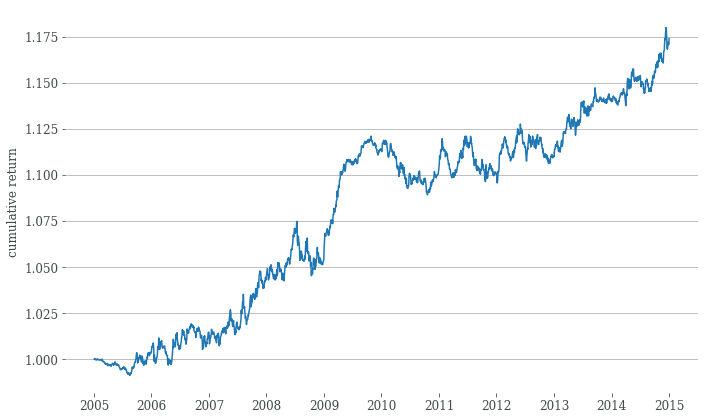

In [42]:
plt.figure(figsize=(10,6))
plt.plot(ret_train.index, sim_train.r_cum)
plt.ylabel("cumulative return")
plt.savefig("../results/portfolio_example.png",dpi=300)
plt.show()

In [43]:
sim_test = run_portfolio(alpha_hl=2, cov_hl=14, 
                          vol_target=0.043158, tx_cost=0.000989, returns=ret_test)

In [44]:
r_cum = sim_test.r_cum[-1]
r_bar = np.mean(sim_test.R)*255
vol = sim_test.vol*np.sqrt(255)
sharpe = r_bar/(vol)

df = pd.DataFrame(data=sim_test.r_cum, columns=['r_cum'])
df['max_level'] = df['r_cum'].expanding().max()
df['drawdown'] = 1.0-df['r_cum']/df['max_level']

max_dd = float(df['drawdown'].max())

{"IR":sharpe, "max_drawdown":max_dd}

{'IR': -0.2733752229965464, 'max_drawdown': 0.1288276108134242}

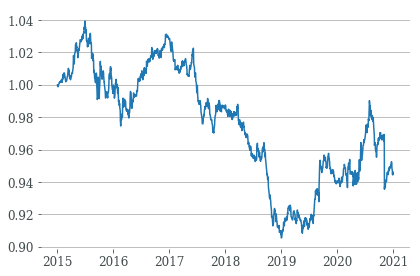

In [45]:
plt.figure()
plt.plot(ret_test.index, sim_test.r_cum)
plt.show()

In [46]:
results = leaderboard.sort_values('run')

In [47]:
results

,run,alpha_hl,cov_hl,vol_target,tx_cost,IR,max_drawdown,mean_return,score
132,0,31,9,0.043999,0.000351,0.139377,0.151505,0.003273,2.474714
100,1,8,34,0.031812,0.000254,0.253672,0.091228,0.006335,2.247053
70,2,5,5,0.042209,0.000541,0.402837,0.070904,0.010732,2.142405
114,3,49,3,0.109279,0.000264,0.260011,0.117881,0.008190,2.325984
14,4,11,32,0.029092,0.000549,0.775524,0.036061,0.017322,1.956040
...,...,...,...,...,...,...,...,...,...
102,147,12,5,0.141436,0.000446,0.401153,0.106244,0.012949,2.249286
10,148,3,3,0.029470,0.000778,0.789753,0.033081,0.016760,1.947498
35,149,2,4,0.026733,0.000841,0.578197,0.049846,0.011791,2.049377
62,150,2,14,0.026978,0.000849,0.374886,0.061738,0.008469,2.125960


/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/Users/gmaher/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible wi

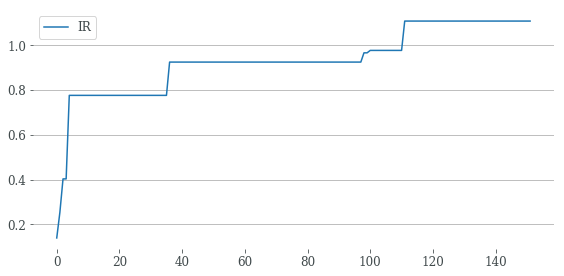

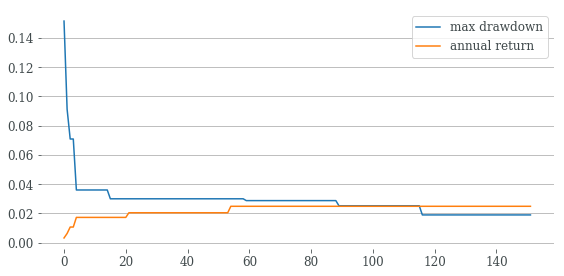

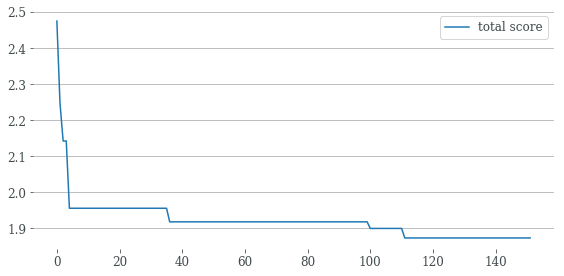

In [48]:
plt.figure(figsize=(8,4))

plt.plot(results['run'], results['IR'].expanding().max(), label='IR')
plt.legend()
plt.savefig("../results/ir.png",dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(results['run'], results['max_drawdown'].expanding().min(), label='max drawdown')
plt.plot(results['run'], results['mean_return'].expanding().max(), label='annual return')
plt.legend()
plt.savefig("../results/dr.png",dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(results['run'], results['score'].expanding().min(), label='total score')
plt.legend()
plt.savefig("../results/score.png",dpi=300)
plt.show()

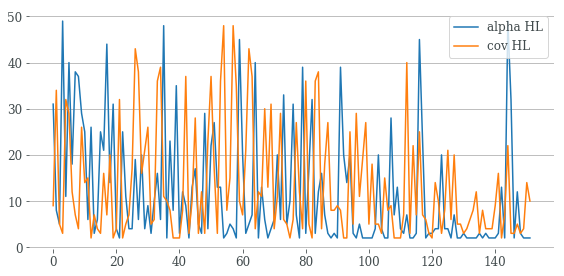

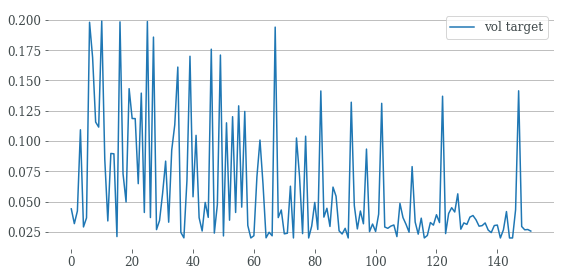

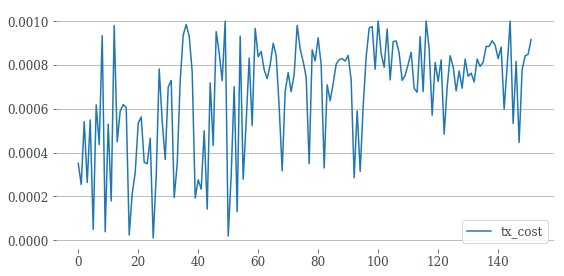

In [49]:
plt.figure(figsize=(8,4))
plt.plot(results['run'], results['alpha_hl'], label='alpha HL')
plt.plot(results['run'], results['cov_hl'], label='cov HL')
plt.legend()
plt.savefig("../results/hl.png",dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(results['run'], results['vol_target'], label='vol target')
plt.legend()
plt.savefig("../results/vol.png",dpi=300)
plt.show()

plt.figure(figsize=(8,4))
plt.plot(results['run'], results['tx_cost'], label='tx_cost')
plt.legend()
plt.savefig("../results/tx.png",dpi=300)
plt.show()